In [1]:
import numpy as np
import pandas as pd
import time
import sys
import pyproj
from pyproj import Proj, transform, CRS
from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
import pylab as pl
import matplotlib
import seaborn as sns
#sns.set_style("darkgrid")
from datetime import datetime, date
import datetime
import csv
from collections import defaultdict
from pathlib import Path
import glob
import shutil
import os
os.environ["PROJ_LIB"] = "/Users/onurhanaydin/opt/anaconda3/envs/geo_env2/share/basemap/epsg"
from mpl_toolkits.basemap import Basemap, shiftgrid
import PseudoNetCDF as pnc
from PseudoNetCDF import PNC
from PseudoNetCDF.pncparse import pncparse
from PseudoNetCDF.coordutil import gettimes
import pyproj
import pygeos
import xarray as xr
import nctoolkit as nc
import rioxarray
from netCDF4 import Dataset as NetCDFFile 
import icartt as ic
import geopandas as gpd
import fiona
from shapely.geometry import Polygon, Point
from geopy.geocoders import Nominatim
import timeit
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
#pd.set_option("display.max_columns", 20)
#pd.set_option("display.max_rows", 20) 
pd.options.display.float_format = "{:.3f}".format 

path = "/Users/onurhanaydin/Desktop/MSc/3/Satellite Climatology/Project/"
opath = "/Users/onurhanaydin/Desktop/"

Please install CDO version 1.9.7 or above: https://code.mpimet.mpg.de/projects/cdo/ or https://anaconda.org/conda-forge/cdo


The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.


In [49]:
ds = xr.open_dataset(opath+"noaa_sfc.nc")
ds

<xarray.Dataset>
Dimensions:  (lat: 180, lon: 360, time: 1548)
Coordinates:
  * lat      (lat) float32 89.5 88.5 87.5 86.5 85.5 ... -86.5 -87.5 -88.5 -89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
  * time     (time) datetime64[ns] 1891-01-01 1891-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/download_gate....
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2020 1.0x1.0 Monthly ...
    history:          Created 07/2021  based on V2020 data obtained via ftp
    References:       https://www.psl.noaa.gov/data/gridded/data.gpcc.html

What I did here:
- Ordered latitude by number otherwise I had to perform slicing operation from higher number to lower number. So, the algorithm didn't work in this case.
- Decided to work on just Europe region.
- Preferred the the last 30 years of the dataset to have more accurate datasets.

In [50]:
ds_new = ds.sortby(ds.lat)
ds_new = ds_new.sel(lat=slice(35, 71), lon=slice(10, 30), time=slice("1990-01-01","2019-12-01"))
ds_new

<xarray.Dataset>
Dimensions:  (lat: 36, lon: 20, time: 360)
Coordinates:
  * lat      (lat) float32 35.5 36.5 37.5 38.5 39.5 ... 66.5 67.5 68.5 69.5 70.5
  * lon      (lon) float32 10.5 11.5 12.5 13.5 14.5 ... 25.5 26.5 27.5 28.5 29.5
  * time     (time) datetime64[ns] 1990-01-01 1990-02-01 ... 2019-12-01
Data variables:
    precip   (time, lat, lon) float32 ...
Attributes:
    Original_Source:  http://www.dwd.de/en/FundE/Klima/KLIS/int/GPCC/GPCC.htm...
    Reference:        Users of the data sets are kindly requested to give fee...
    original_source:  ftp://ftp-anon.dwd.de/pub/data/gpcc/html/download_gate....
    Conventions:      CF 1.0
    dataset_title:    Global Precipitation Climatology Centre (GPCC)
    title:            GPCC Full Data Reanalysis Version 2020 1.0x1.0 Monthly ...
    history:          Created 07/2021  based on V2020 data obtained via ftp
    References:       https://www.psl.noaa.gov/data/gridded/data.gpcc.html

## Building algorithm

### 20th percentile

In [234]:
# Create empthy lists

date=[]
q2=[]
val=[]
lat=[]
lon=[]

###############################################################
# Calculate the quartiles of each pixel for whole timesteps.
# Then, precipitation value of each pixel is calculated for the relevant month.
# Put them all into separate lists if precipitation is smaller than threshold value.

for d in np.arange(0,ds_new.time.shape[0]): # Since "time" is not float, I must use "shape", instead of "len"
    for x in np.arange(0, len(ds_new.lon)):           
        for y in np.arange(0, len(ds_new.lat)):
        
            q_2=ds_new["precip"].isel(lon=x, lat=y).quantile(0.2).values
            v=ds_new["precip"].isel(lon=x, lat=y, time=d).values
            q=float(q)
            v=float(v)
            
            if v<q_2:
                
                date.append(str(ds_new.time[d]))
                lon.append(str(ds_new.lon[x]))
                lat.append(str(ds_new.lat[y]))
                q2.append(q_2)
                val.append(v)
                
            else:
                break
                

### Creating Dataframe

In [235]:
d = {'Date': date, 'Montly Precipitation': val,
     "20th Percentile":q2,
     "lat":lat, "lon":lon}

df = pd.DataFrame(data=d)
df

,Date,Montly Precipitation,20th Percentile,lat,lon
0,<xarray.DataArray 'time' ()>\narray('1990-02-0...,0.980,4.584000110626221,"<xarray.DataArray 'lat' ()>\narray(35.5, dtype...","<xarray.DataArray 'lon' ()>\narray(10.5, dtype..."
1,<xarray.DataArray 'time' ()>\narray('1990-02-0...,5.920,7.848000049591064,"<xarray.DataArray 'lat' ()>\narray(36.5, dtype...","<xarray.DataArray 'lon' ()>\narray(10.5, dtype..."
2,<xarray.DataArray 'time' ()>\narray('1990-02-0...,0.610,3.069999933242798,"<xarray.DataArray 'lat' ()>\narray(35.5, dtype...","<xarray.DataArray 'lon' ()>\narray(11.5, dtype..."
3,<xarray.DataArray 'time' ()>\narray('1990-02-0...,0.000,0.6979999899864197,"<xarray.DataArray 'lat' ()>\narray(35.5, dtype...","<xarray.DataArray 'lon' ()>\narray(12.5, dtype..."
4,<xarray.DataArray 'time' ()>\narray('1990-05-0...,0.750,1.5019999742507932,"<xarray.DataArray 'lat' ()>\narray(35.5, dtype...","<xarray.DataArray 'lon' ()>\narray(25.5, dtype..."
...,...,...,...,...,...
2126,<xarray.DataArray 'time' ()>\narray('2019-08-0...,0.650,2.896000051498413,"<xarray.DataArray 'lat' ()>\narray(35.5, dtype...","<xarray.DataArray 'lon' ()>\narray(24.5, dtype..."
2127,<xarray.DataArray 'time' ()>\narray('2019-08-0...,0.010,0.28399999141693105,"<xarray.DataArray 'lat' ()>\narray(36.5, dtype...","<xarray.DataArray 'lon' ()>\narray(24.5, dtype..."
2128,<xarray.DataArray 'time' ()>\narray('2019-08-0...,0.130,3.0159999847412107,"<xarray.DataArray 'lat' ()>\narray(37.5, dtype...","<xarray.DataArray 'lon' ()>\narray(24.5, dtype..."
2129,<xarray.DataArray 'time' ()>\narray('2019-08-0...,3.590,6.963999843597412,"<xarray.DataArray 'lat' ()>\narray(38.5, dtype...","<xarray.DataArray 'lon' ()>\narray(24.5, dtype..."


In [12]:
# Let's extract only date from the "Date" column

for i in np.arange(0, len(df.Date)):
    
    df.Date[i] = df.Date[i][36:43]
    df.lat[i] = df.lat[i][34:38]
    df.lon[i] = df.lon[i][34:38]

df

,Unnamed: 0,Date,Montly Precipitation,20th Percentile,lat,lon,Year,Month
0,0,1990-02-01,0.980,4.584,35.5,10.5,1990,2
1,1,1990-02-01,5.920,7.848,36.5,10.5,1990,2
2,2,1990-02-01,0.610,3.070,35.5,11.5,1990,2
3,3,1990-02-01,0.000,0.698,35.5,12.5,1990,2
4,4,1990-05-01,0.750,1.502,35.5,25.5,1990,5
...,...,...,...,...,...,...,...,...
2126,2126,2019-08-01,0.650,2.896,35.5,24.5,2019,8
2127,2127,2019-08-01,0.010,0.284,36.5,24.5,2019,8
2128,2128,2019-08-01,0.130,3.016,37.5,24.5,2019,8
2129,2129,2019-08-01,3.590,6.964,38.5,24.5,2019,8


In [39]:
df.index = pd.to_datetime(df.Date, format="%Y-%m")
df.drop(["Date","Unnamed: 0"], axis=1, inplace=True)
df['Year'] = df.index.year 
df['Month'] = df.index.month
df.reset_index(inplace=True)
df.to_csv(path+"europe.csv")
df

,Date,Montly Precipitation,20th Percentile,lat,lon,Year,Month
0,1990-02-01,0.980,4.584,35.500,10.500,1990,2
1,1990-02-01,5.920,7.848,36.500,10.500,1990,2
2,1990-02-01,0.610,3.070,35.500,11.500,1990,2
3,1990-02-01,0.000,0.698,35.500,12.500,1990,2
4,1990-05-01,0.750,1.502,35.500,25.500,1990,5
...,...,...,...,...,...,...,...
2126,2019-08-01,0.650,2.896,35.500,24.500,2019,8
2127,2019-08-01,0.010,0.284,36.500,24.500,2019,8
2128,2019-08-01,0.130,3.016,37.500,24.500,2019,8
2129,2019-08-01,3.590,6.964,38.500,24.500,2019,8


In [45]:
df=pd.read_csv(path+"europe.csv", sep=",", usecols=[2,3,4,5,6,7])
df

,Montly Precipitation,20th Percentile,lat,lon,Year,Month
0,0.980,4.584,35.500,10.500,1990,2
1,5.920,7.848,36.500,10.500,1990,2
2,0.610,3.070,35.500,11.500,1990,2
3,0.000,0.698,35.500,12.500,1990,2
4,0.750,1.502,35.500,25.500,1990,5
...,...,...,...,...,...,...
2126,0.650,2.896,35.500,24.500,2019,8
2127,0.010,0.284,36.500,24.500,2019,8
2128,0.130,3.016,37.500,24.500,2019,8
2129,3.590,6.964,38.500,24.500,2019,8


### Data Engineering

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2131 entries, 0 to 2130
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Montly Precipitation  2131 non-null   float64
 1   20th Percentile       2131 non-null   float64
 2   lat                   2131 non-null   float64
 3   lon                   2131 non-null   float64
 4   Year                  2131 non-null   int64  
 5   Month                 2131 non-null   int64  
dtypes: float64(4), int64(2)
memory usage: 100.0 KB


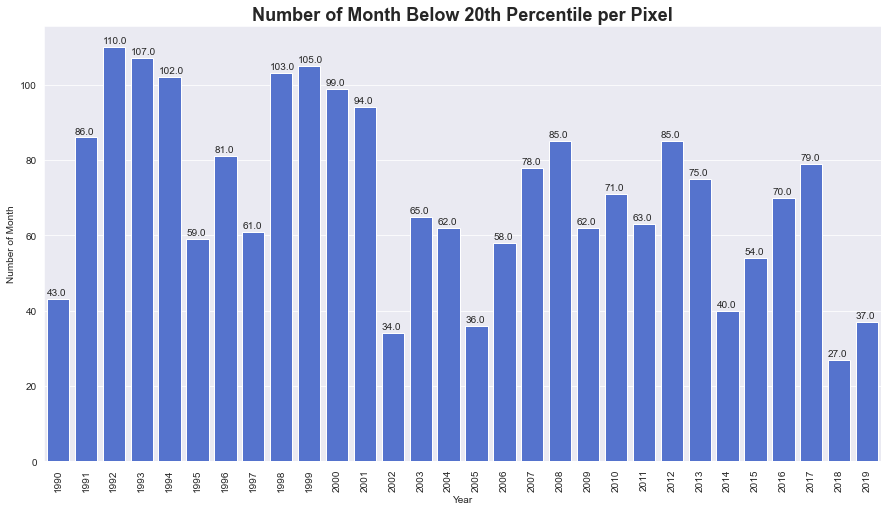

In [62]:
plt.figure(figsize=(15,8))

ax = sns.barplot(data=df, y=df["Year"].value_counts(), x=df["Year"].value_counts().index, color="royalblue")
plt.title("Number of Month Below 20th Percentile per Pixel", fontsize=18, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Month")
plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x(), p.get_height()+1));

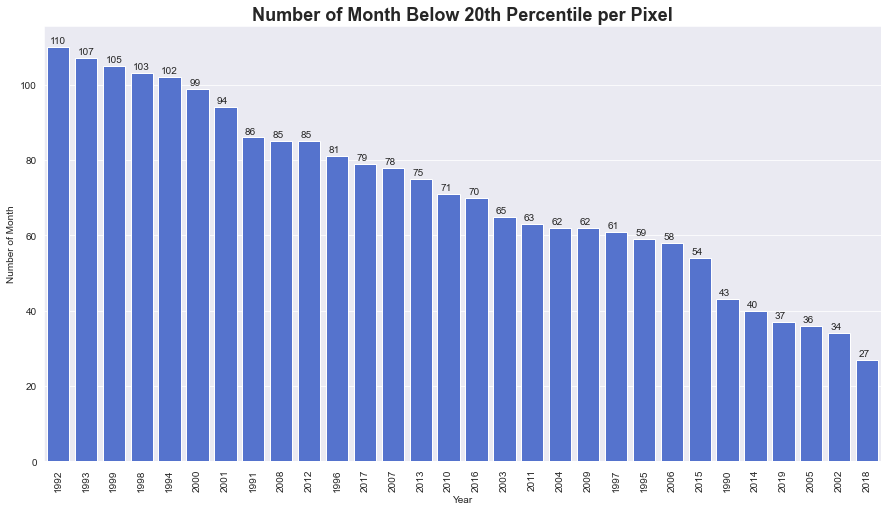

In [63]:
fig, ax= plt.subplots(figsize=(15,8))

ax=sns.countplot(data=df, x="Year", order=df.Year.value_counts().index, color="royalblue")
plt.title("Number of Month Below 20th Percentile per Pixel", fontsize=18, fontweight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Number of Month")
plt.xticks(rotation=90)

for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()+0.1, p.get_height()+1));

### Mean Annual Precipitation

In [54]:
avg=[]
date=np.arange(1990,2020)

for i in np.arange(0, 360, 12):
    
    avg.append(ds_new.precip[i:i+12,:,:].mean().values)
    
d_avg = {'Year': date, 'Mean Precipitation': avg}

df_m = pd.DataFrame(data=d_avg)

df_m["Mean Precipitation"]=df_m["Mean Precipitation"].astype(float)

df_m

,Year,Mean Precipitation
0,1990,55.461
1,1991,56.444
2,1992,55.226
3,1993,55.206
4,1994,53.956
5,1995,59.457
6,1996,56.586
7,1997,56.600
8,1998,63.656
9,1999,58.991


In [55]:
df_m.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Year                30 non-null     int64  
 1   Mean Precipitation  30 non-null     float64
dtypes: float64(1), int64(1)
memory usage: 608.0 bytes


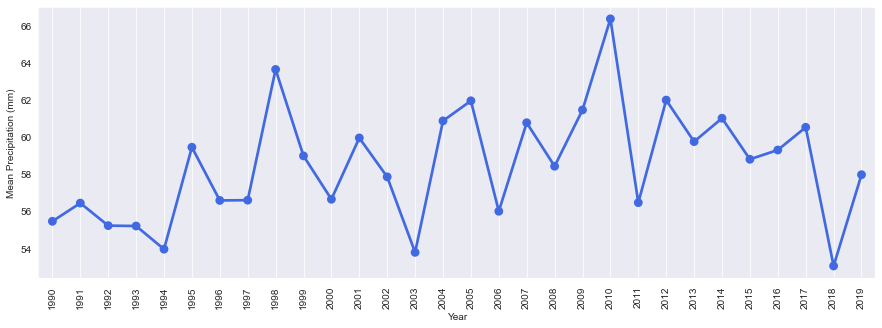

In [64]:
fig, ax= plt.subplots(figsize=(15,5))

ax=sns.pointplot(data=df_m, x="Year", y="Mean Precipitation", color="royalblue")
ax.set_xlabel("Year")
ax.set_ylabel("Mean Precipitation (mm)")
plt.grid()
plt.xticks(rotation=90);

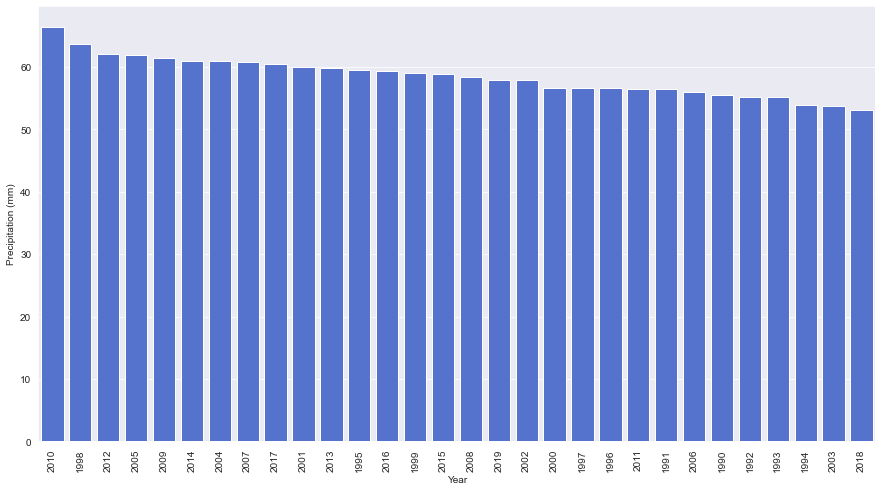

In [66]:
fig, ax= plt.subplots(figsize=(15,8))

ax=sns.barplot(data=df_m, x="Year", y="Mean Precipitation", 
               order=df_m.sort_values("Mean Precipitation", ascending=False).Year, color="royalblue")
ax.set_xlabel("Year")
ax.set_ylabel("Precipitation (mm)")
plt.xticks(rotation=90);